In [3]:
# 数据预处理
import pandas as pd

comp_fin = pd.read_excel('dataset/FS_Combas.xlsx',skiprows=[0,2]) # 上市公司财务报表：2020-2023
comp_basic = pd.read_excel('dataset/HLD_Copro.xlsx',skiprows=[1,2]) # 上市公司基本情况 （行业/注册资本）
volitions = pd.read_excel('dataset/STK_Violation_Main.xlsx',skiprows=[1,2]) # 违规记录
shareholders = pd.read_excel('dataset/HLD_Shareholders.xlsx',skiprows=[1,2]) # 股东
pri_basic = pd.read_excel('dataset/PRI_Basic.xlsx',skiprows=[1,2]) # 民营企业情况 （行业/区域）


/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workboo

In [2]:
# 不考虑时序信息的财务信息

comp_fin_single = comp_fin.drop_duplicates(subset=['证券代码'],keep='last')
comp_fin_single = comp_fin_single.drop(['证券简称','统计截止日期','报表类型'], axis=1)
comp_fin_single = comp_fin_single.fillna(value=0)



In [3]:
# 1.公司节点
# 2.股东节点
# 3.构建关系 投资关系cc cp pc 
set_fin_comps = set(comp_fin['证券代码'].to_list()) # 包含财务信息的节点数量：5322

set_comps = set(comp_basic['Stkcd'].to_list()) # 上市公司的节点数量：5510

set_selected_comps = set_fin_comps & set_comps # 节点数量：5321 具有财务信息的上市公司




In [4]:
set_temp_nodes = [] # (code,name)
big_comp_names = []

for idx, row in comp_basic.iterrows():
    code = row['Stkcd']
    if code in set_selected_comps:
        set_temp_nodes.append((code,row['Conme']))
        big_comp_names.append(row['Conme'])

In [5]:
df1 = shareholders[['Stkcd','S0301a']]
df1_single_10 = df1.groupby('Stkcd').head(10)

temp_list = []
# temp_dict = {}
temp_p_code = 1000000
temp_c_code = 2000000

for index,row in df1_single_10.iterrows():
    name = row['S0301a']
    cname = name.split("-",1)[0]
    if cname not in big_comp_names: 
        if cname not in temp_list:
            if len(cname) > 3:
                set_temp_nodes.append((temp_c_code,cname))
                # temp_dict[cname] = temp_c_code
                temp_list.append(cname)
                temp_c_code += 1 
            else:
                set_temp_nodes.append((temp_p_code,cname))  
                # temp_dict[cname] = temp_c_code  
                temp_list.append(cname)
                temp_p_code += 1

In [6]:
mapper_code2name = {}
mapper_name2code = {}
mapper_idx2code = {}
mapper_code2idx = {}
mapper_idx2name = {}
mapper_name2idx = {}

for index, item in enumerate(set_temp_nodes):
    mapper_idx2code[index] = item[0]
    mapper_code2idx[item[0]] = index
    mapper_code2name[item[0]] = item[1]
    mapper_name2code[item[1]] = item[0]
    mapper_idx2name[index] = item[1]
    mapper_name2idx[item[1]] = index

In [7]:
import json
dicts = {'mapper_idx2name':mapper_idx2name,'mapper_name2idx':mapper_name2idx,'mapper_code2name':mapper_code2name,'mapper_name2code':mapper_name2code,'mapper_idx2code':mapper_idx2code,'mapper_code2idx':mapper_code2idx}
# 将列表转换为 JSON 格式的字符串
json_str = json.dumps(dicts)

# 将字符串写入文件
with open("mapper_dicts.json", "w") as file:
    file.write(json_str)

In [8]:
node_comp_num = len(big_comp_names) # 上市公司节点数量
node_num = len(set_temp_nodes) # 节点总数量

invested_comps = []
invest_ids = []
rel_invest_cc = [] # c2c 投资关系
rel_invest_pc = [] # p2c 投资关系
for index,row in df1_single_10.iterrows():
    name = row['S0301a']
    cname = name.split("-",1)[0]
    if cname in mapper_name2idx and row['Stkcd'] in mapper_code2idx:
        idx_investor = mapper_name2idx[cname]
        idx_invested = mapper_code2idx[row['Stkcd']]
        if len(cname)>3:
            rel_invest_cc.append((idx_investor,idx_invested))
        else:
            rel_invest_pc.append((idx_investor,idx_invested))    

In [9]:
import numpy as np

np.save('relation_invest_cc.npy',rel_invest_cc)
np.save('relation_invest_pc.npy',rel_invest_pc)

In [12]:
node_num = len(set_temp_nodes) # 节点总数量
node_dim = len(comp_fin_single.columns) # 特征纬度
node_comp_num = len(big_comp_names) # 上市公司节点数量

data_mat = np.zeros((node_num, node_dim)) # 特征矩阵
label_mat = np.ones(node_num).astype(int) * -1 # complete missing lbl as -1

In [14]:
# 处理特征 & 标签
risk_comps = list(set(volitions['Symbol'].to_list()))

for code in set_selected_comps:
    idx = mapper_code2idx[code]
    data_mat[idx] = comp_fin_single[comp_fin_single['证券代码'] == code].to_numpy()
    if code in risk_comps:
        label_mat[idx] = 1
    else:
        label_mat[idx] = 0
    

In [16]:
np.save('financial_statement.npy', data_mat)
np.save('risk_label.npy', label_mat)

In [ ]:
counts = volitions['Symbol'].value_counts()
risk_list = []
for index in counts.index:
    time = counts[index]
    if time > 3 :
        risk_list.append(index)


In [13]:
import json
file = 'data/mapper_dicts.json'
with open(file,"r") as f: 
    maps = json.load(f)

map_i2c = maps['mapper_idx2code']
map_c2i = maps['mapper_code2idx']

In [19]:
import numpy as np
node_num = 5317
label_mat = np.zeros(node_num).astype(int)
for code in risk_list:
    if str(code) in map_c2i: 
        idx = map_c2i[str(code)]
        label_mat[idx] = 1
print(label_mat.tolist().count(1))

559


In [20]:
np.save('data/listed_comp/risk_bc_label_4.npy', label_mat)

In [22]:
aid = []
for  idx,label in enumerate(label_mat):
    if label==1:
        aid.append(idx)

In [17]:
# 连续数值离散化 
_data_mat = data_mat
from sklearn.preprocessing import Normalizer, KBinsDiscretizer
# bins strategy 2
bins_encoder = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='quantile')  # uniform, quantile, kmeans
mask_sign = _data_mat < 0
_data_mat[mask_sign] *= -1
# data_mat[dim_need_to_norm] = bins_encoder.fit_transform(data_mat[dim_need_to_norm])
_data_mat = bins_encoder.fit_transform(data_mat)
_data_mat[mask_sign] *= -1

np.save('features_100.npy', _data_mat)

/Users/seanyaoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/seanyaoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/seanyaoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/seanyaoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/seany

In [2]:
import numpy as np

rel_invest_cc = np.load('relation_invest_cc.npy')
rel_invest_pc = np.load('relation_invest_pc.npy')
cc_src, cc_tar = zip(*rel_invest_cc)
pc_src, pc_tar = zip(*rel_invest_pc)

In [ ]:
import dgl
# 建异质图

data1= {
    ('company','invest_cc','company'):(cc_src,cc_tar),
    ('person','invest_pc','company'):(pc_src,pc_tar)
}

g = dgl.heterograph(data1)
import networkx as nx
import matplotlib.pyplot as plt


# 转换为同质图
# homo_g = dgl.to_homogeneous(g)
bg = dgl.to_bidirected(g)
nx_g = dgl.to_networkx(bg)

# 绘制图形
nx.draw(nx_g, with_labels=True)
plt.figure(figsize=(10,8),dpi=150)
plt.show()

In [3]:
# 建同质图
import dgl
import json
file = 'mapper_dicts.json'
with open(file,"r") as f: 
    maps = json.load(f)

map_i2c = maps['mapper_idx2code']
map_c2i = maps['mapper_code2idx']

rel_bc2bc = []

# 上市公司投资图
for rel in rel_invest_cc:
    src = rel[0]
    if src <5321:
        rel_bc2bc.append((rel[0],rel[1]))

src_bigc, tar_bigc = zip(*rel_bc2bc)



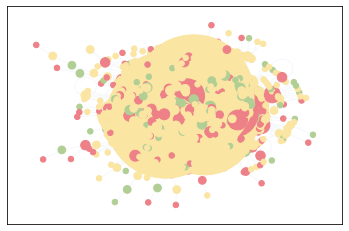

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

tmp1 = set(src_bigc)
tmp2 = set(tar_bigc)
tmp = tmp1.union(tmp2)

mapper_sample = {d:i for i,d in enumerate(tmp)}

u0= [ mapper_sample[d] for d in  src_bigc ]
v0 = [ mapper_sample[d] for d in  tar_bigc ]

data2 = (u0,v0)
g2 = dgl.graph(data2)# bg2 = dgl.to_bidirected(g2)
nx_g2 = dgl.to_networkx(g2)

# 绘制图形
nx_G2 = nx_g2.to_undirected()

pos = nx.kamada_kawai_layout(nx_G2)
#颜色 大小
color_comp = '#fbe5a3'
color_person = '#b1cf95'
risk_comp = '#ee8087'
# edge_color = '#4d72be'
edge_color = '#f5f8fc'

#标签
labels = np.load('risk_label.npy')
n_num = len(tmp)
# node_color = [color_person if 1000000 <= map_i2c[idx] <=2000000 else color_comp if labels[idx]== 0 else risk_comp for idx in tmp]
node_color = [ risk_comp if labels[idx]== 1 else color_comp for idx in tmp]
tt = np.random.randint(n_num,size=300)
for k in tt:
    node_color[k] = color_person

de = dict(nx_G2.degree()) #转换成dict
de2 = [de[v]*30 for v in sorted(de.keys(), reverse=False)]
nx.draw_networkx(nx_G2, pos, node_size=de2, with_labels = False, node_color=node_color, linewidths=None, width=1.0, edge_color =edge_color)
# nx.draw_networkx_labels(nx_G,pos, font_size=6,font_color='white')
# nx.draw(nx_G, pos, with_labels=False, node_color=[[.7, .7, .7]])

# plt.figure(figsize=(20,16),dpi=150)
plt.savefig("cc_5000",dpi=600)
plt.show()

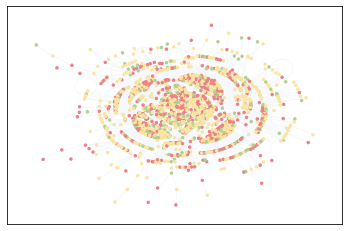

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

tmp1 = set(src_bigc)
tmp2 = set(tar_bigc)
tmp = tmp1.union(tmp2)

mapper_sample = {d:i for i,d in enumerate(tmp)}

u0= [ mapper_sample[d] for d in  src_bigc ]
v0 = [ mapper_sample[d] for d in  tar_bigc ]

data2 = (u0,v0)
g2 = dgl.graph(data2)# bg2 = dgl.to_bidirected(g2)
nx_g2 = dgl.to_networkx(g2)

# 绘制图形
nx_G2 = nx_g2.to_undirected()

pos = nx.kamada_kawai_layout(nx_G2)
# pos = nx.spring_layout(nx_G)
#颜色 大小
color_comp = '#fbe5a3'
color_person = '#b1cf95'
risk_comp = '#ee8087'
# edge_color = '#4d72be'
edge_color = '#f5f8fc'

#标签
labels = np.load('risk_label.npy')
n_num = len(tmp)
# node_color = [color_person if 1000000 <= map_i2c[idx] <=2000000 else color_comp if labels[idx]== 0 else risk_comp for idx in tmp]
node_color = [ risk_comp if labels[idx]== 1 else color_comp for idx in tmp]
tt = np.random.randint(n_num,size=350)
for k in tt:
    node_color[k] = color_person

de = dict(nx_G2.degree()) #转换成dict
de2 = [de[v]*30 for v in sorted(de.keys(), reverse=False)]
nx.draw_networkx(nx_G2, pos, node_size=6, with_labels = False, node_color=node_color, linewidths=None, width=1.0, edge_color =edge_color)
# nx.draw_networkx_labels(nx_G,pos, font_size=6,font_color='white')
# nx.draw(nx_G, pos, with_labels=False, node_color=[[.7, .7, .7]])

# plt.figure(figsize=(20,16),dpi=150)
plt.savefig("cc_5000_2",dpi=600)
plt.show()

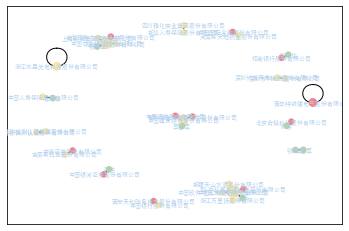

In [12]:
# 示意图
import random
import networkx as nx
import matplotlib.pyplot as plt

sample100 = random.sample(rel_bc2bc,25)
# sample100 = rel_bc2bc

src_bigc1, tar_bigc1 = zip(*sample100)

t1 = set(src_bigc1)
t2 = set(tar_bigc1)
t = t1.union(t2)
# nodes2show = list(t)
mapper_sample100 = {d:i for i,d in enumerate(t)}


u = [ mapper_sample100[d] for d in  src_bigc1 ]
v = [ mapper_sample100[d] for d in  tar_bigc1 ]

data3 = (u,v)

g3 = dgl.graph(data3)

bg3 = dgl.to_bidirected(g3)
nx_g3 = dgl.to_networkx(bg3)

# 绘制图形
nx_G = nx_g3.to_undirected()
# pos = nx.kamada_kawai_layout(nx_G)
pos = nx.spring_layout(nx_G)



#颜色 大小
color_comp = '#fbe5a3'
color_person = '#b1cf95'
risk_comp = '#ee8087'
# edge_color = '#4d72be'
edge_color = '#f5f8fc'


#degree
de = dict(nx_G.degree()) #转换成dict
de2 = [de[v]*30 for v in sorted(de.keys(), reverse=False)]

m = maps['mapper_idx2name']
#标签
co_name = { mapper_sample100[idx]:m[str(idx)] for idx in t }
labels = np.load('risk_label.npy')
node_color = [ risk_comp if labels[idx]== 1 else color_comp for idx in t]
n_num = len(t)
tt = np.random.randint(n_num,size=10)
ttt = ['张伟','张丽华','姚宗','李国军','王衡']
for k in tt:
    node_color[k] = color_person
    co_name[k] = ttt[np.random.randint(5)]

from pylab import mpl
 
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus']=False

# nx.draw_networkx(nx_G, pos, node_size=de2, with_labels = False, node_color=node_color, linewidths=None, width=1.0, edge_color =edge_color)
nx.draw_networkx(nx_G, pos, node_size=de2, with_labels = False, node_color=node_color, linewidths=None, width=1.0)

nx.draw_networkx_labels(nx_G,pos,co_name, font_size=6,font_color='#b4d1ec')
# nx.draw_networkx_labels(nx_G,pos,co_name, font_size=6)

plt.savefig("cc_exaple25",dpi=600)
plt.show()

# network绘图参考
1. https://blog.csdn.net/u010970317/article/details/106218381?spm=1001.2101.3001.6650.5&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-5-106218381-blog-100997231.235%5Ev35%5Epc_relevant_increate_t0_download_v2&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-5-106218381-blog-100997231.235%5Ev35%5Epc_relevant_increate_t0_download_v2&utm_relevant_index=8
2. https://blog.csdn.net/Ducky_/article/details/125173457
3. https://blog.csdn.net/qq_45864291/article/details/127433252

/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
import pandas as pd

pri_basic = pd.read_excel('dataset/PRI_Basic.xlsx',skiprows=[1,2]) # 民营企业情况 （行业/区域）

import json

file = 'data/mapper_dicts.json'
with open(file,"r") as f: 
    maps = json.load(f)

industrys = {}
t = pri_basic[['Stkcd','Nindcd']]
keys = set(t['Stkcd'])
map_c2i = maps['mapper_code2idx']

for idx, row in t.iterrows():
    industry = row['Nindcd']
    code = row['Stkcd']
    if str(code)in map_c2i:
        index = map_c2i[str(code)]
        if industry not in industrys:
            industrys[industry] = set([map_c2i[str(code)]])
        else:
            industrys[industry].add(map_c2i[str(code)])


# 将列表转换为 JSON 格式的字符串
for key,value in industrys.items():
    industrys[key] = list(value)

dicts = {'industry':industrys}
json_str = json.dumps(dicts)

# 将字符串写入文件
with open("dicts_hyper.json", "w") as file:
    file.write(json_str)


In [18]:
# DGL 图

import numpy as np
import dgl as dl
import torch
from sklearn.model_selection import train_test_split

def load_hete_graph():
    rel_bc2bc = np.load('data/listed_comp/relation_invest_bc2bc.npy')
    rel_provide_bc2bc = np.load('data/listed_comp/relation_provide_bc2bc.npy')
    rel_sale_bc2bc = np.load('data/listed_comp/relation_sale_bc2bc.npy')

    feature_fin = np.load('data/listed_comp/features_norm_bc.npy')
    feature_basic = np.load('data/listed_comp/features_basic_bc.npy')

    # feature_basic1 = np.nan_to_num(feature_basic)
    # print(feature_basic1.shape)
    # fin_feature_ttl = np.load('data/features_100.npy')

    src, tgt = zip(*rel_bc2bc)
    src_p,tgt_p = zip(*rel_provide_bc2bc)
    src_s,tgt_s = zip(*rel_sale_bc2bc)
    # print(isinstance(src,tuple))
    src_homo = []
    tgt_homo = []
    for i,_ in enumerate(src):
        src_homo.append(src[i])
        tgt_homo.append(tgt[i])
        src_homo.append(tgt[i])
        tgt_homo.append(src[i])
    for i,_ in enumerate(src_p):
        src_homo.append(src_p[i])
        tgt_homo.append(tgt_p[i])    
        src_homo.append(tgt_p[i])
        tgt_homo.append(src_p[i])  
    for i,_ in enumerate(src_s):
        src_homo.append(src_s[i])
        tgt_homo.append(tgt_s[i])
        src_homo.append(tgt_s[i])
        tgt_homo.append(src_s[i])



    graph_data = { ('company','invest_bc2bc','company') : (src,tgt),
                   ('company','provide_bc2bc','company') : (src_p,tgt_p),
                   ('company','sale_bc2bc','company') : (src_s,tgt_s),
                   ('company','homo','company') : (src_homo,tgt_homo)
                   }

    g = dl.heterograph(graph_data)

    num = g.num_nodes()


    feats_fin = torch.tensor(feature_fin[:num])
    feats_bsc = torch.tensor(feature_basic[:num])
    feats = torch.cat([feats_fin,feats_bsc],1)
    # print(feats)

    # feats = torch.from_numpy(np.nan_to_num(feats))

    isnan = np.isnan(feats)
    print("空值：",True in isnan)
    
    g.nodes['company'].data['feature'] = feats.float()

    dict_node_feats =  {'company': feats.float()}

    return g, feats, dict_node_feats

def construct_dgl_graph():
    g, feats, dict_node_feats = load_hete_graph()
    labels = np.load('data/listed_comp/risk_bc_label_4.npy')
    print(len(labels))
    
    num = g.num_nodes('company')
    
    g.nodes['company'].data['label'] = torch.tensor(labels)

    # g.nodes['company'].data['train_mask'] = th.zeros(num, dtype=th.bool).bernoulli(0.6)
    lbs = labels
    
    print('Generate dataset partition.')
    train_ratio = 0.6
    test_ratio = 0.5
    index = list(range(len(lbs)))
    dataset_l = len(lbs)
    train_idx, rest_idx, train_lbs, rest_lbs = train_test_split(index, lbs, stratify=lbs, train_size=train_ratio, random_state=2, shuffle=True)
    valid_idx, test_idx, _,_ = train_test_split(rest_idx, rest_lbs, stratify=rest_lbs, test_size=test_ratio, random_state=2, shuffle=True)
    train_mask = torch.zeros(dataset_l, dtype=torch.bool)
    train_mask[np.array(train_idx)] = True
    valid_mask = torch.zeros(dataset_l, dtype=torch.bool)
    valid_mask[np.array(valid_idx)] = True
    test_mask = torch.zeros(dataset_l, dtype=torch.bool)
    test_mask[np.array(test_idx)] = True
    
    g.nodes['company'].data['train_mask'] = train_mask
    g.nodes['company'].data['valid_mask'] = valid_mask
    g.nodes['company'].data['test_mask'] = test_mask
    
    # dgl.save_graphs("lst_comps.dgl",g)
    return g

g = construct_dgl_graph()
dl.save_graphs("data/lst_comps6.dgl",g)

空值： False
5317
Generate dataset partition.


In [12]:
feat = g.nodes['company'].data['feature']



In [11]:
def generate_edges_labels(edges, labels, train_idx):
    row, col = edges
    edge_labels = []
    edge_train_mask = []
    train_idx = set(train_idx)
    for i, j in zip(row, col):
        i = i.item()
        j = j.item()
        if labels[i] == labels[j]:
            edge_labels.append(1)
        else:
            edge_labels.append(-1)
        if i in train_idx and j in train_idx:
            edge_train_mask.append(1)
        else:
            edge_train_mask.append(0)
    edge_labels = torch.Tensor(edge_labels).long()
    edge_train_mask = torch.Tensor(edge_train_mask).bool()
    return edge_labels, edge_train_mask

lbs = g.ndata['label']
train_mask = g.ndata['train_mask'].int()
train_idx = torch.nonzero(train_mask==1).squeeze()

homo_edges = g.edges(etype='homo')
homo_labels, homo_train_mask = generate_edges_labels(homo_edges, lbs, train_idx)
g.edges['homo'].data['label'] = homo_labels
g.edges['homo'].data['train_mask'] = homo_train_mask


In [27]:
# 统计
# 转换为同质图
import dgl
homo_g = dgl.to_homogeneous(g, ndata=['feature'])
print(homo_g.edges())
edges = homo_g.edges()
inconsis = 0
consis = 0
labels = g.nodes['company'].data['label']
aid = []
for  idx,label in enumerate(labels):
    if label==1:
        aid.append(idx)

for j in range(len(edges[0])):
    u, v = edges[0][j], edges[1][j]
    if u in aid and v in aid:
        consis += 1
    elif (u in aid and v not in aid) or (u not in aid and v in aid):
        inconsis += 1
print("inconsis: ", inconsis)
print("consis: ", consis)
print("%: ", inconsis/(inconsis+consis))
print("all%: ", inconsis/len(edges[0]))

(tensor([3772, 3819, 3886,  ..., 5262, 5262, 5267]), tensor([   0,    1,    2,  ..., 1135, 1513, 4286]))
inconsis:  613
consis:  58
%:  0.9135618479880775
all%:  0.12927035006326446


In [4]:
import dgl

g = dgl.load_graphs('data/lst_comps.dgl')[0][0]
relation1 = g.edge_type_subgraph(['invest_bc2bc'])
relation2 = g.edge_type_subgraph(['provide_bc2bc'])
relation3 = g.edge_type_subgraph(['sale_bc2bc'])
edges = relation3.edges()
inconsis = 0
consis = 0
labels = g.nodes['company'].data['label']
aid = []
for  idx,label in enumerate(labels):
    if label==1:
        aid.append(idx)

for j in range(len(edges[0])):
    u, v = edges[0][j], edges[1][j]
    if u in aid and v in aid:
        consis += 1
    elif (u in aid and v not in aid) or (u not in aid and v in aid):
        inconsis += 1
print("inconsis: ", inconsis)
print("consis: ", consis)
print("%: ", inconsis/(inconsis+consis))
print("all%: ", inconsis/len(edges[0]))


inconsis:  135
consis:  5
%:  0.9642857142857143
all%:  0.14563106796116504


In [1]:
import dgl 
g = dgl.load_graphs('data/lst_comps7.dgl')[0][0]

train_mask = g.ndata['train_mask'].bool()
train_label = g.ndata['label'][train_mask]
valid_mask = g.ndata['valid_mask'].bool()
valid_label = g.ndata['label'][valid_mask]
test_mask = g.ndata['test_mask'].bool()
test_label = g.ndata['label'][test_mask]

print( "train: pos number:%d ,所占比例：%1f " % (len(train_label[train_label==1]) , len(train_label[train_label==1]) / len(train_mask[train_mask==1])))
print( "valid: pos number:%d ,所占比例：%1f " % (len(valid_label[valid_label==1]) , len(valid_label[valid_label==1]) / len(valid_mask[valid_mask==1])))
print( "test: pos number:%d, 所占比例：%1f " % (len(test_label[test_label==1]) , len(test_label[test_label==1]) / len(test_mask[test_mask==1])))


train: pos number:224 ,所占比例：0.105362 
valid: pos number:111 ,所占比例：0.105413 
test: pos number:224, 所占比例：0.104771 


In [1]:
# 时间序列数据处理
import pandas as pd

comp_fin = pd.read_excel('dataset/FS_Combas.xlsx',skiprows=[0,2]) # 上市公司财务报表：2020-2023

print(len(comp_fin))

comp_fin = comp_fin[comp_fin['报表类型'] == 'A']

print(len(comp_fin))

comp_fin = comp_fin.drop(['证券简称','统计截止日期','报表类型'], axis=1)

# 缺失值处理
# comp_fin = comp_fin.fillna(value=0)

missing_percent = comp_fin.isnull().sum() / len(comp_fin) * 100

/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


127733
70859


In [2]:
# 归一化
def Normal(data, col,method):
    x=data[col].astype(float)

    if method =='min-max':
        x_min=min(x)
        x_max=max(x)
        d=x_max-x_min
        data[col]=[(i-x_min)*1.0/d for i in x]
        # del data[col]
        return 1
    elif method =='zero-score':
        mu=np.mean()
        std=np.std()
        data[col]=[(x-mu)*1.0/std for i in x]
        # del data[col]
        return 1
    


In [3]:
# print(missing_percent)
columns_to_drop = missing_percent[missing_percent > 20].index # 筛选出缺失值比例超过60%的列
comp_fin_dropped = comp_fin.drop(columns=columns_to_drop) # 处理后的数据集

# 缺失值处理
comp_fin_processed = comp_fin_dropped.fillna(value=0)



# comp_fin_precessed = comp_fin_processed.drop(['证券代码'], axis=1) （5317*15*24）




 

In [6]:
# 归一化
import numpy as np
col2norm = comp_fin_processed.columns.tolist()
col2norm = col2norm[1:]

for col in col2norm:
    Normal(comp_fin_processed,col,method='min-max')

In [7]:
import json
import torch
file = 'data/mapper_dicts.json'
with open(file,"r") as f: 
    maps = json.load(f)

map_i2c = maps['mapper_idx2code']
map_c2i = maps['mapper_code2idx']

seq_fin = torch.zeros(5317,15,24)
times_seq = {code : 0 for code in map_c2i}

for index,row in comp_fin_processed.iterrows():
    code = str(int(row['证券代码']))
    if code in map_c2i:
        idx = map_c2i[code]
        if idx < 5317:
            time = times_seq[code]
            x = torch.tensor(row)
            seq_fin[idx][time] = x
            times_seq[code] = time + 1



    


In [8]:
import numpy as np
np.save('data/listed_comp/financial_seq_normal.npy',seq_fin)  # 财务信息序列 

In [15]:
from utils import *
from torch.utils.data import Subset

# g, features, dict_node_feats = load_hete_graph3()

# train_mask = g.ndata['train_mask']
# train_indices = torch.nonzero(train_mask).squeeze()
# train_data = Subset(features, train_indices)

# valid_mask = g.ndata['valid_mask']
# valid_indices = torch.nonzero(valid_mask).squeeze()
# valid_data = Subset(features, valid_indices)

# test_mask = g.ndata['test_mask']
# test_indices = torch.nonzero(test_mask).squeeze()
# test_data = Subset(features, test_indices)



train_data,val_data,test_data = split_data()

train_idx = train_data.indices
valid_idx = val_data.indices
test_idx = test_data.indices



In [8]:
import pickle
import torch
from torch.utils.data import Subset
import numpy as np
from utils import *

train_idx = np.load('model_save/train_idx.npy')
print(train_idx)
g, features, _ = load_hete_graph3()
train_data = Subset(features, train_idx)
print(train_data.indices)


# 将 train_data_list 转换回 Subset 类型的 train_data
train_data = torch.utils.data.Subset(features, train_idx)

def my_split_data(train_idx, val_idx, test_idx):
    _, features, _ = load_hete_graph3()
    train_data = Subset(features, train_idx)
    val_data = Subset(features, val_idx)
    test_data = Subset(features, test_idx)
    return train_data, val_data, test_data


[ 460 3636  923 ... 1370 2148 4170]
[ 460 3636  923 ... 1370 2148 4170]


In [2]:
from utils import * # eigen_decomposision()  _add_undirected_graph_positional_embedding() 

import numpy as np
fin_seq = np.load('data/listed_comp/financial_seq.npy')
comp_fin = pd.read_excel('dataset/FS_Combas.xlsx',skiprows=[0,2]) # 上市公司财务报表：2020-2023




/root/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
